In [1]:
import numpy as np
import pandas as pd
import random
import copy
import warnings
import sys
import itertools
import pickle

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support
from scipy.io import loadmat

sys.path.append("../../")
from ACME.ACME import ACME 
from ACME.visual_utils import *
sys.path.remove("../../")

warnings.filterwarnings("ignore")

np.random.seed(0)
random.seed(0)

# AcME-AD to explain Isolation Forest on Glass Dataset 
Explanation of anomalies in the training set.

In [2]:
# create AD dataset from glass 
data = pd.read_csv("ad_datasets/glass.data", index_col=0)
data.columns  = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"]

types = data["Type"].unique()
features = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]

data["Target"] = data["Type"].apply(lambda x: 0 if x in [1,2,3,4] else 1)

## IF training

In [3]:
def if_score_function(model, data): 
    return 0.5 * (-model.decision_function(data) + 1)

In [4]:
iforest = IsolationForest(n_estimators = 100, random_state = 0, max_samples = 32).fit(data[features])

data["Score"] = if_score_function(iforest, data[features])
data["Prediction"] = iforest.predict(data[features])
data["Prediction"] = data["Prediction"].apply(lambda x:0 if x==1 else 1)

In [5]:
precision, recall, f1, _ = precision_recall_fscore_support(data["Target"], data["Prediction"], average = "binary")
print("Precision: ", round(precision,4), "| Recall: ", round(recall,4), "| F1-score: ", round(f1,4))

Precision:  0.7241 | Recall:  0.8235 | F1-score:  0.7706


## AcME-AD explanations
Explain predicted anomalies originally belonging to Class 7

In [6]:
# check how many points of Type 7 are correctly classified as outliers 
data[data["Type"] == 7]["Prediction"].value_counts()

Prediction
1    28
0     1
Name: count, dtype: int64

In [7]:
# explain only predicted anomalies (Prediction = 1) of Type 7
data_to_explain = data[(data["Type"] == 7) & (data["Prediction"] == 1)].reset_index(drop = True)

In [8]:
n_quantiles = 70
acme_exp = ACME(iforest, "Score", features, K=n_quantiles, task = "ad", score_function=if_score_function)
acme_exp = acme_exp.explain(data, True)

Explanation with default weights

In [9]:
features_ranking = pd.DataFrame(columns = features, )
ratios = pd.DataFrame(np.zeros((len(data_to_explain), len(features))), columns = features)
deltas = pd.DataFrame(np.zeros((len(data_to_explain), len(features))), columns = features)
changes = pd.DataFrame(np.zeros((len(data_to_explain), len(features))), columns = features)
distances_to_changes = pd.DataFrame(np.zeros((len(data_to_explain), len(features))), columns = features)

for i in data_to_explain.index: 
    anomaly = data_to_explain.loc[i]
    loc_exp = acme_exp.explain_local(anomaly)
    feature_importance_table = loc_exp.feature_importance(local = True, sum_local = True)
    features_ranking.loc[i] = feature_importance_table["importance"].rank(axis=0, ascending = False, method="min")

    ratios.loc[i] = feature_importance_table["ratio"]
    deltas.loc[i] = feature_importance_table["delta"]
    changes.loc[i] = feature_importance_table["change"]
    distances_to_changes.loc[i] = feature_importance_table["distance_to_change"]

feature_ranking_count = features_ranking.apply(pd.Series.value_counts, axis = 0).fillna(0).astype(int)
feature_ranking_count = feature_ranking_count/feature_ranking_count.sum(axis = 0)

Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature imp

### Global insights

Global barplot

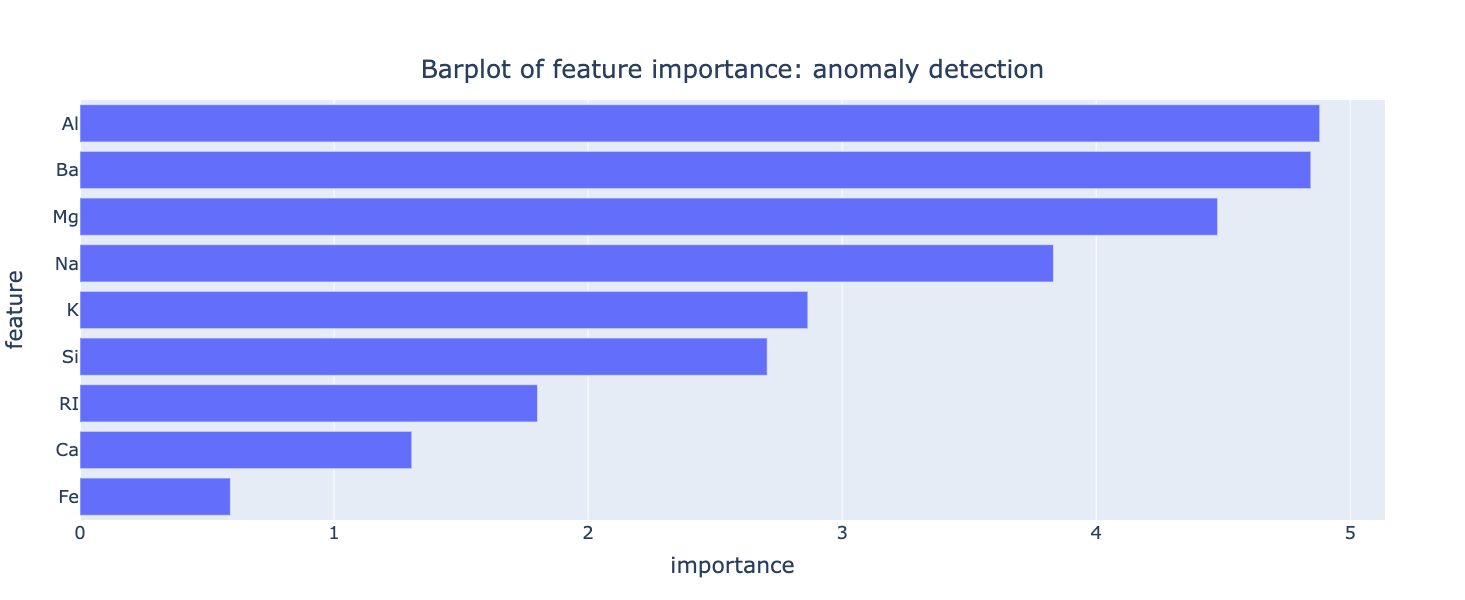

In [10]:
global_bar_plot = acme_exp.bar_plot()
global_bar_plot.update_layout(width=10*100, height=6*100, font_size=18)
global_bar_plot.show()

Stacked barplot to visualize how many times (the number of anomalies) each feature is ranked in a given position

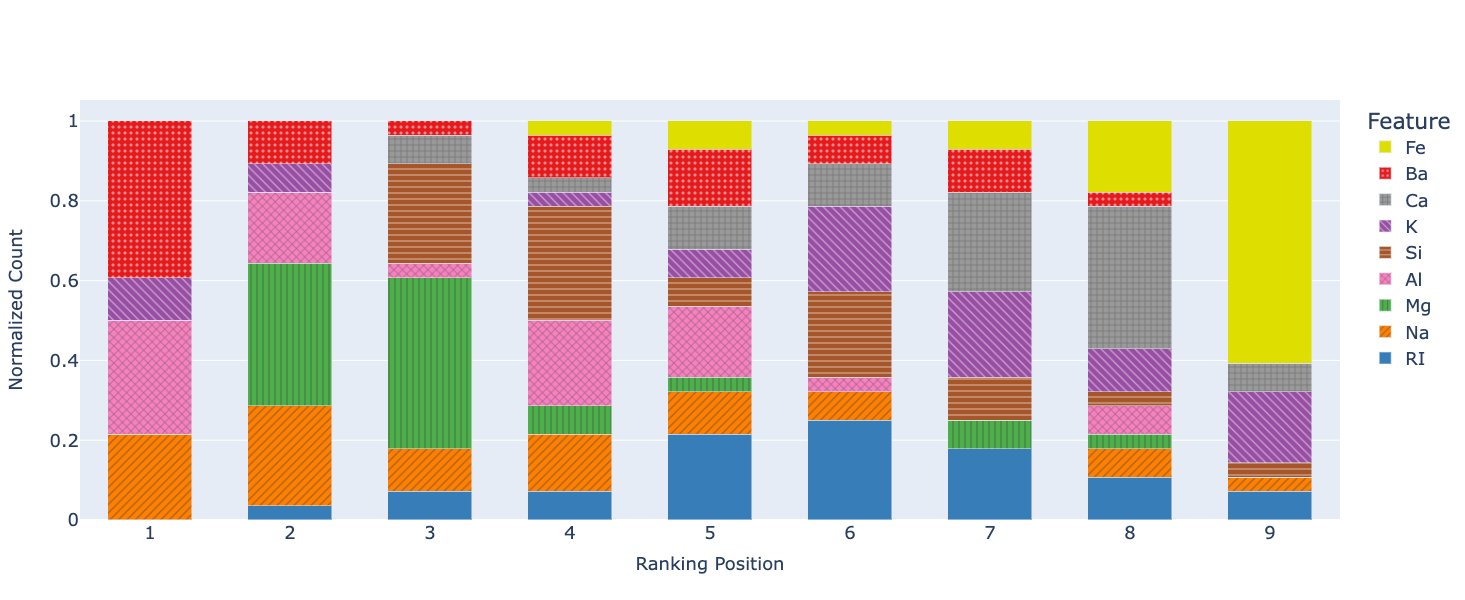

In [11]:
acme_default_weights_fig = feature_importance_distribution_barplot(feature_ranking_count)
acme_default_weights_fig.update_layout(width=10*100, height=6*100, font_size=18)
acme_default_weights_fig.show()

Sub-scores distributions

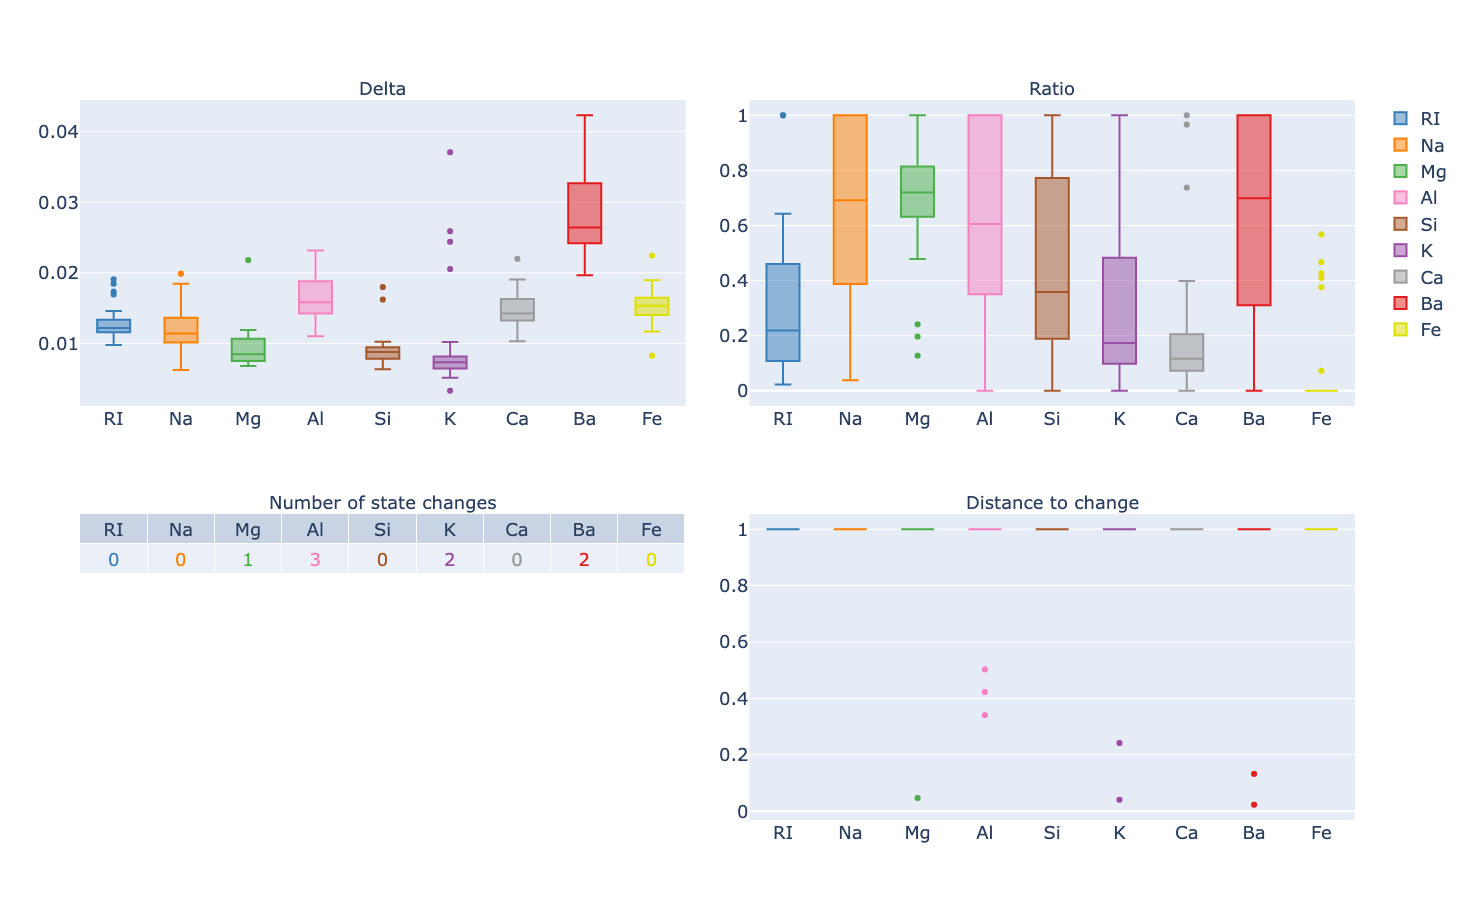

In [12]:
sub_scores_distributions_fig = sub_scores_distributions(ratios, deltas, changes, distances_to_changes)
sub_scores_distributions_fig.update_layout(width=10*1.5*100, height=6*1.5*100, font_size=18)
sub_scores_distributions_fig.show()

### Local explanations

In [13]:
anomaly = data_to_explain.sample(1)
anomaly = anomaly.squeeze()

display(anomaly)

acme_loc = acme_exp.explain_local(anomaly)
acme_loc.feature_importance(local = True, sum_local = False)

RI             1.522470
Na            14.860000
Mg             2.200000
Al             2.060000
Si            70.260000
K              0.760000
Ca             9.760000
Ba             0.000000
Fe             0.000000
Type           7.000000
Target         1.000000
Score          0.514197
Prediction     1.000000
Name: 2, dtype: float64

Using default weights for anomaly detection feature importance


,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
Al,0.684349,0.021864,1.0,0.423184,0.521099,0.499235,0.514197,0.558792
Na,0.999999,0.011062,0.0,1.000000,0.514197,0.503135,0.514197,0.203318
Si,0.999999,0.009820,0.0,1.000000,0.514197,0.504378,0.514197,0.202946
K,0.686125,0.007506,0.0,1.000000,0.516553,0.509047,0.514197,0.139477
RI,0.408897,0.017349,0.0,1.000000,0.524452,0.507103,0.514197,0.086984
Ca,0.398132,0.014462,0.0,1.000000,0.522901,0.508440,0.514197,0.083965
Mg,0.240842,0.010767,0.0,1.000000,0.522371,0.511604,0.514197,0.051399
Ba,0.000000,0.041038,0.0,1.000000,0.555235,0.514197,0.514197,0.012311
Fe,0.000000,0.017505,0.0,1.000000,0.531703,0.514197,0.514197,0.005252


Summary plot

Using default weights for anomaly detection feature importance


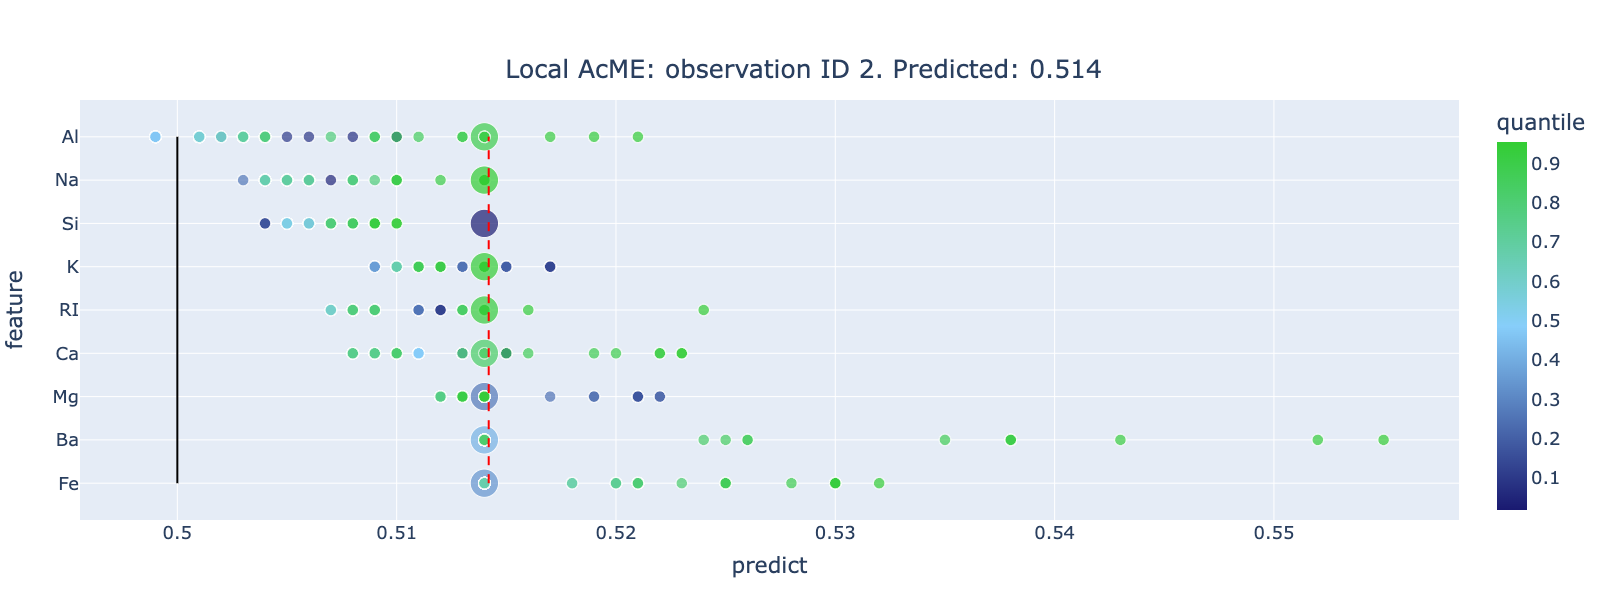

In [14]:
acme_loc_fig = acme_loc.summary_plot(local=True)
acme_loc_fig.update_layout(width=10*100, height=6*100, font_size=18)
acme_loc_fig.show()

Feature exploration plot (explore feature 'Al')

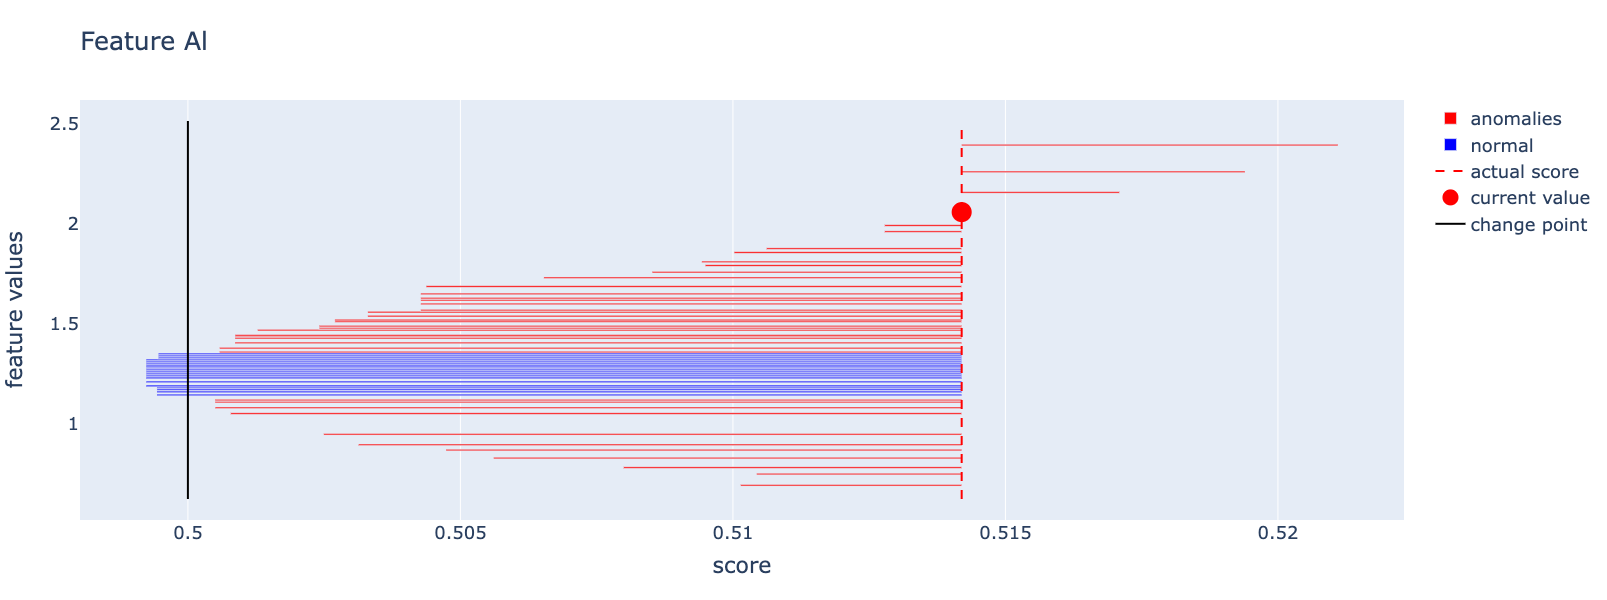

In [15]:
acme_loc_fig_fe = acme_loc.feature_exploration(local=True, plot=True, feature="Al")
acme_loc_fig_fe.update_layout(width=10*100, height=6*100, font_size=18)
acme_loc_fig_fe.show()

# Comparison with LocalDIFFI

In [16]:
sys.path.append("../")
from anomaly_detection_notebook.diffi.diffi_interpretability_module import *
from anomaly_detection_notebook.diffi.diffi_sklearn_mod_functions import * 
from anomaly_detection_notebook.diffi.diffi_utils import * 
sys.path.remove("../")

In [17]:
# convert data_to_explain into numpy array
data_to_explain_numpy = data_to_explain[features].to_numpy()
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(iforest, data_to_explain_numpy)
diffi_normalized_count = normalized_count(ord_idx_diffi_te)
diffi_normalized_count = diffi_normalized_count.drop(columns=["Feature ID", "Feature"]).transpose()
diffi_normalized_count.columns = features

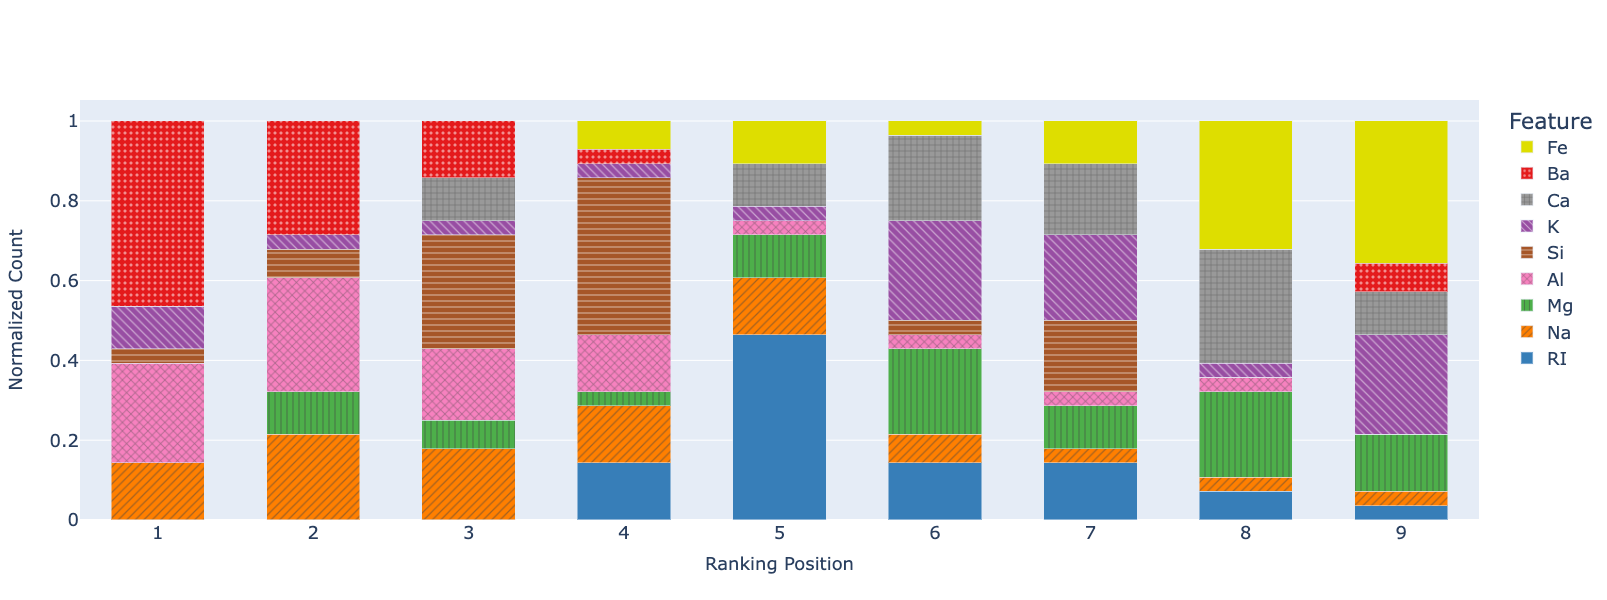

In [18]:
diffi_normalized_count_fig = feature_importance_distribution_barplot(diffi_normalized_count)
diffi_normalized_count_fig.update_layout(width=10*100, height=6*100, font_size=18)
diffi_normalized_count_fig.show()

## Comparison with SHAP

In [19]:
import shap 

def if_score_function_shap(X): 
    return 0.5 * (-iforest.decision_function(X) + 1)

shap_exp = shap.KernelExplainer(if_score_function_shap, data[features])
shap_values = shap_exp.shap_values(data_to_explain[features])
df_shap_abs = pd.DataFrame(np.abs(shap_values), columns = features)
shap_rank = df_shap_abs.rank(axis=1, ascending=False, method="min")

shap_rank_count = shap_rank.apply(pd.Series.value_counts, axis = 0).fillna(0).astype(int)
shap_rank_count = shap_rank_count/shap_rank_count.sum(axis = 0)

Using 213 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 28/28 [00:25<00:00,  1.08it/s]


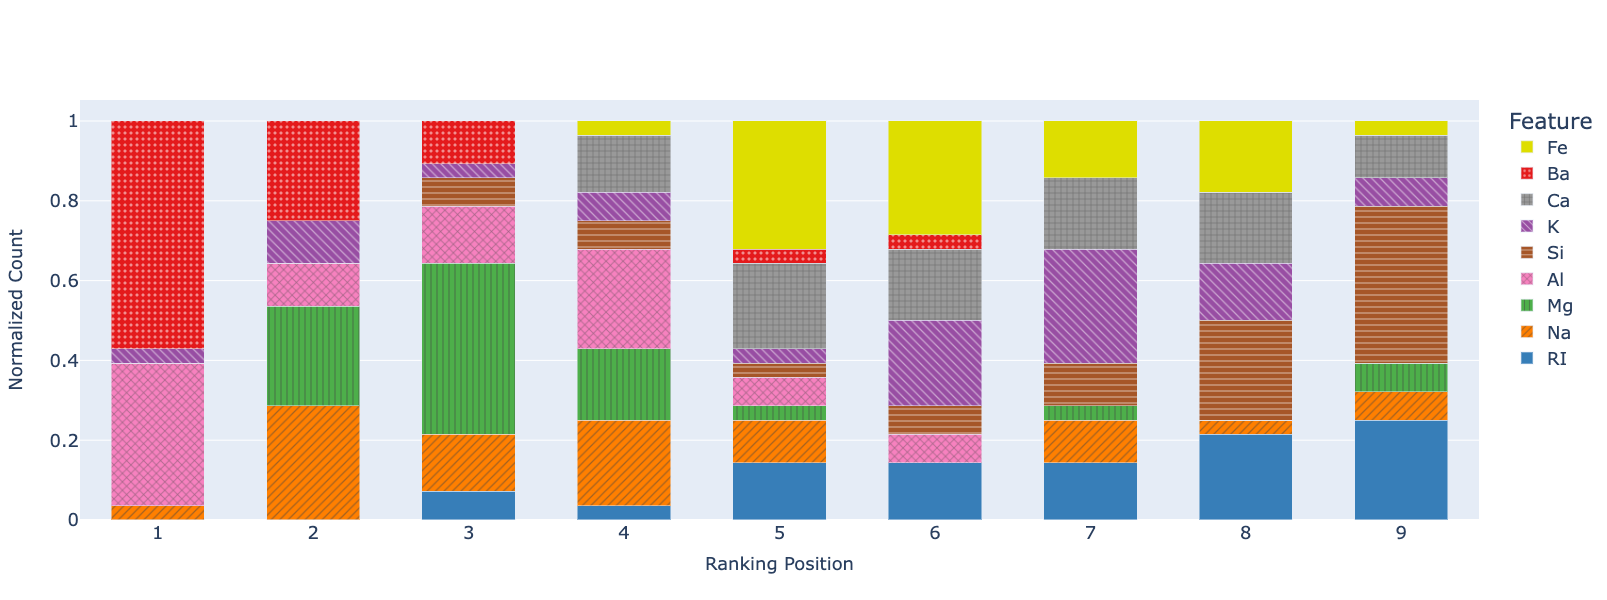

In [20]:
shap_rank_fig = feature_importance_distribution_barplot(shap_rank_count)
shap_rank_fig.update_layout(width=10*100, height=6*100, font_size=18)
shap_rank_fig.show()